In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import os
import numpy as np

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [ ]:
data_dir = './hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

print("Class Names: {}".format(class_names))
print("There are {} batches in the training set".format(len(dataloaders['train'])))
print("There are {} batches in the test set".format(len(dataloaders['val'])))
print("There are {} training images".format(dataset_sizes['train']))
print("There are {} test images".format(dataset_sizes['val']))

Class Names: ['ants', 'bees']
There are 61 batches in the training set
There are 39 batches in the test set
There are 244 training images
There are 153 test images


In [ ]:
# Load ResNet18
model_conv = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


In [ ]:
# Freeze all layers in the network
for param in model_conv.parameters():
  param.require_grad = False

In [ ]:
# Get the number of inputs of the last layer
num_ftrs = model_conv.fc.in_features

# Reconstruct the last layer to have only 2 classes
model_conv.fc = nn.Linear(num_ftrs, 2)

In [ ]:
if torch.cuda.is_available():
  model_conv = model_conv.cuda()

In [ ]:
iteration = 0
correct = 0
for inputs, labels in dataloaders['train']:
  if iteration == 1:
    break
  inputs = Variable(inputs)
  labels = Variable(labels)
  if torch.cuda.is_available():
    inputs = inputs.cuda()
    labels = labels.cuda()

  print("For one iteration: ")
  print("Input Shape: ", inputs.shape)
  print("Labels Shape: ", labels.shape)
  print("Labels are: {}".format(labels))
  output = model_conv(inputs)
  print("Output Tensor: ", output)
  print("Output Shape: ", output.shape)
  _, predicted = torch.max(output, 1)
  print("Predicted: ", predicted)
  print("Predicted Shape: ", predicted.shape)
  correct += (predicted == labels).sum()
  print("Correct Predictions: ", correct)

  iteration += 1


For one iteration: 
Input Shape:  torch.Size([4, 3, 224, 224])
Labels Shape:  torch.Size([4])
Labels are: tensor([0, 0, 0, 0], device='cuda:0')
Output Tensor:  tensor([[-0.5848, -0.2372],
        [-0.7441,  0.5140],
        [-1.0227, -0.6788],
        [-0.6640,  0.5385]], device='cuda:0', grad_fn=<AddmmBackward0>)
Output Shape:  torch.Size([4, 2])
Predicted:  tensor([1, 1, 1, 1], device='cuda:0')
Predicted Shape:  torch.Size([4])
Correct Predictions:  tensor(0, device='cuda:0')


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
def lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
  # Decay LR by 0.1 every lr_decay_epoch
  lr = init_lr * (0.1 ** (epoch // lr_decay_epoch))

  if epoch % lr_decay_epoch == 0:
    print("LR is set to {}".format(lr))

  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

  return optimizer


In [ ]:
num_epochs = 25
for epoch in range(num_epochs):
  exp_lr_scheduler.step()
  correct = 0
  for images, labels in dataloaders['train']:
    images = Variable(images)
    labels = Variable(labels)
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()

    optimizer.zero_grad()
    outputs = model_conv(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum()

  train_acc = 100 * correct / dataset_sizes['train']
  print("Epoch [ {} / {} ], Loss: {:.4f}, Train Accuracy: {}%".format(epoch + 1, num_epochs, loss.item(), train_acc))



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [ 1 / 25 ], Loss: 0.2994, Train Accuracy: 70.4917984008789%
Epoch [ 2 / 25 ], Loss: 0.3276, Train Accuracy: 77.45901489257812%
Epoch [ 3 / 25 ], Loss: 0.0761, Train Accuracy: 77.04917907714844%
Epoch [ 4 / 25 ], Loss: 0.3680, Train Accuracy: 84.8360595703125%
Epoch [ 5 / 25 ], Loss: 1.0148, Train Accuracy: 83.19671630859375%
Epoch [ 6 / 25 ], Loss: 0.9586, Train Accuracy: 78.68852233886719%
Epoch [ 7 / 25 ], Loss: 1.4424, Train Accuracy: 88.52458190917969%
Epoch [ 8 / 25 ], Loss: 0.0340, Train Accuracy: 86.88523864746094%
Epoch [ 9 / 25 ], Loss: 1.0578, Train Accuracy: 83.60655212402344%
Epoch [ 10 / 25 ], Loss: 0.1900, Train Accuracy: 80.73770141601562%
Epoch [ 11 / 25 ], Loss: 0.1116, Train Accuracy: 84.01638793945312%
Epoch [ 12 / 25 ], Loss: 0.6776, Train Accuracy: 83.60655212402344%
Epoch [ 13 / 25 ], Loss: 0.4089, Train Accuracy: 90.16393280029297%
Epoch [ 14 / 25 ], Loss: 0.3040, Train Accuracy: 80.73770141601562%
Epoch [ 15 / 25 ], Loss: 0.1647, Train Accuracy: 90.1639328

In [ ]:
model_conv.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for (images, labels) in dataloaders['val']:
    images = Variable(images)
    labels = Variable(labels)
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()

    outputs = model_conv(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print("Test Accuracy {:.3f}%".format(100 * correct / total) )

Test Accuracy 94.771%


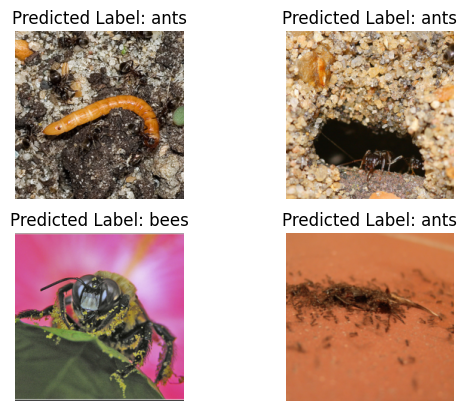

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()

shown_batch = 0
index = 0
with torch.no_grad():
  for (images, labels) in dataloaders['val']:
    if shown_batch == 1:
      break
    shown_batch += 1
    images = Variable(images)
    labels = Variable(labels)
    if torch.cuda.is_available():
      images = images.cuda()
      labels = labels.cuda()
    outputs = model_conv(images)
    _, preds = torch.max(outputs, 1)

    for i in range(4):
      index += 1
      ax = plt.subplot(2, 2, index)
      ax.axis('off')
      ax.set_title("Predicted Label: {}".format(class_names[preds[i]]))
      input_img = images.cpu().data[i]
      inp = input_img.numpy().transpose((1, 2, 0))
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
      inp = np.clip(inp, 0, 1)
      plt.imshow(inp)